In [1]:
#pip install --upgrade pip

In [2]:
#pip install --upgrade Pillow 

In [3]:
from os import path
from wordcloud import WordCloud
import requests
from bs4 import BeautifulSoup
import urllib
import time
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import os
from os import path
from wordcloud import WordCloud, STOPWORDS

def get_some_page_soup(url):
    headers = {'Accept-Language': 'en',
               'X-FORWARDED-FOR': '2.21.184.0'}

    response = requests.get(url, headers=headers)
    assert response.status_code == 200
    some_page_soup = BeautifulSoup(response.text, features="html.parser") # features="html.parser" for pycharm

    return some_page_soup

def get_actor_name(actor_url):

    headers = {'Accept-Language': 'en',
               'X-FORWARDED-FOR': '2.21.184.0'}

    response = requests.get(actor_url, headers=headers)
    actor_page_soup = BeautifulSoup(response.text, features="html.parser")

    actor_name = [(actor_page_soup.find_all('span', attrs={'class': 'itemprop'})[0].text,
                       actor_url)]

    return actor_name


def get_actors_by_movie_soup(cast_page_soup, num_of_actors_limit=None):

    actors_soup = cast_page_soup.find_all('tr', attrs={'class': ('odd', 'even')})

    if num_of_actors_limit != None and num_of_actors_limit <= len(actors_soup):
        actors = [(actors_soup[i].find('img')['alt'],
                   urllib.parse.urljoin(cast_page_soup.find_all('link')[0]['href'], actors_soup[i].find('a')['href']))
                  for i in range(num_of_actors_limit)]
    else:
        actors = [(actors_soup[i].find('img')['alt'],
                   urllib.parse.urljoin(cast_page_soup.find_all('link')[0]['href'], actors_soup[i].find('a')['href']))
                  for i in range(len(actors_soup))]

    return actors

def actors_in_movies(movies, num_of_actors_limit):
    actors, actors_inter = [], []
    for movie in movies:
        # print(movie)
        url = movie[1] + 'fullcredits/'
        # print(url)
        headers = {'Accept-Language': 'en',
                   'X-FORWARDED-FOR': '2.21.184.0'}

        response = requests.get(url, headers=headers)

        assert response.status_code == 200
        cast_page_soup = BeautifulSoup(response.text, features="html.parser")

        # print(cast_page_soup)

        # print(get_actors_by_movie_soup(cast_page_soup, num_of_actors_limit=None))

        actors_inter.append(get_actors_by_movie_soup((cast_page_soup), num_of_actors_limit))
        
    for el in actors_inter:
        for el1 in el:
            if el1 not in actors:
                actors.append(el1)

    return actors


def get_movies_by_actor_soup(actor_page_soup, num_of_movies_limit=None):
    movies = []

    restrictions = ('TV Series', 'Short', 'Video Game',
                    'Video short', 'Video', 'TV Movie',
                    'TV Mini Series', 'TV Series short', 'TV Special',
                    'announced', 'completed', 'voice', 'uncredited', 
                    'pre-production', 'filming', 'post-production')

    movies_soup_all = actor_page_soup.find_all('div',
                                               attrs={'class': 'filmo-category-section'})

    movies_soup = movies_soup_all[0].find_all('div',
                                              attrs={'class': ('filmo-row odd', 'filmo-row even')})

    if num_of_movies_limit == None:
        movies = [(movies_soup[i].find('a').text,
                   urllib.parse.urljoin(actor_page_soup.find_all('link')[0]['href'], movies_soup[i].find('a')['href']))
                  for i in range(len(movies_soup))
                  if all(restriction not in movies_soup[i].text for restriction in restrictions)]
    else:
        for i in range(len(movies_soup)):
            if len(movies) == num_of_movies_limit:
                break
            if all(restriction not in movies_soup[i].text for restriction in restrictions):
                movies.append((movies_soup[i].find('a').text,
                               urllib.parse.urljoin(actor_page_soup.find_all('link')[0]['href'], movies_soup[i].find('a')['href'])))

    return movies


def movies_by_actors(actors, num_of_movies_limit):
    movies, movies_inter = [], []
    for actor in actors:
        # print(actor)
        url = actor[1]
        # print(url)
        headers = {'Accept-Language': 'en',
                   'X-FORWARDED-FOR': '2.21.184.0'}

        response = requests.get(url, headers=headers)
        assert response.status_code == 200
        actor_page_soup = BeautifulSoup(response.text, features="html.parser")

        movies_inter.append(get_movies_by_actor_soup((actor_page_soup), num_of_movies_limit))

    for el in movies_inter:
        for el1 in el:
            if el1 not in movies:
                movies.append(el1)

    return movies


In [4]:
def get_movie_descriptions_by_actor_soup(actor_page_soup):

    movies = []
    description = []

    restrictions = ('TV Series', 'Short', 'Video Game',
                    'Video short', 'Video', 'TV Movie',
                    'TV Mini Series', 'TV Series short', 'TV Special',
                    'announced', 'completed', 'voice', 'uncredited',
                    'pre-production', 'filming', 'post-production')

    movies_soup_all = actor_page_soup.find_all('div',
                                               attrs={'class': 'filmo-category-section'})

    movies_soup = movies_soup_all[0].find_all('div',
                                              attrs={'class': ('filmo-row odd', 'filmo-row even')})


    movies = [(movies_soup[i].find('a').text,
              urllib.parse.urljoin(actor_page_soup.find_all('link')[0]['href'], movies_soup[i].find('a')['href']))
              for i in range(len(movies_soup))
              if all(restriction not in movies_soup[i].text for restriction in restrictions)]

    for i in range(len(movies)):
        text_all = get_some_page_soup(movies[i][1])
        text = text_all.find('span', attrs={'class': "sc-16ede01-2 gXUyNh"}).text
        description.append(text)

    return description


In [5]:
popular_actors = [('Dwayne Johnson', 'https://www.imdb.com/name/nm0425005/'), 
                  ('Chris Hemsworth', 'https://www.imdb.com/name/nm1165110/'),
                  ('Robert Downey Jr.', 'https://www.imdb.com/name/nm0000375/'), 
                  ('Akshay Kumar', 'https://www.imdb.com/name/nm0474774/'), 
                  ('Jackie Chan', 'https://www.imdb.com/name/nm0000329/'), 
                  ('Bradley Cooper', 'https://www.imdb.com/name/nm0177896/'), 
                  ('Adam Sandler', 'https://www.imdb.com/name/nm0001191/'),  
                  ('Scarlett Johansson', 'https://www.imdb.com/name/nm0424060/'), 
                  ('Sofia Vergara', 'https://www.imdb.com/name/nm0005527/'), 
                  ('Chris Evans', 'https://www.imdb.com/name/nm0262635/')]


In [6]:
# function to save the movies description for popular actors list in separate txt files
def actors_file(popular_actors):
    for actor in popular_actors:
        actor_page_soup = get_some_page_soup(actor[1])
        result = get_movie_descriptions_by_actor_soup(actor_page_soup)
        #print(result)
        textfile = open(f"{actor[0]}.txt", "w", encoding="utf-8")
        for element in result:
            textfile.write(element + "\n")
        textfile.close()


In [7]:
actors_file(popular_actors)

# Dwayne Johnson (Using txt file)

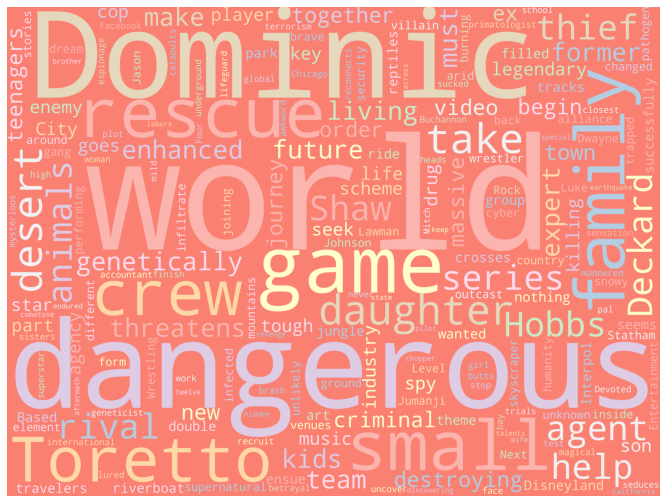

In [8]:
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
text = open(path.join(d, 'Dwayne Johnson.txt')).read()

stopwords = set(STOPWORDS)
stopwords.add("will")
stopwords.add("way")
stopwords.add("find")
stopwords.add("gets")
stopwords.add("return")
stopwords.add("three")
stopwords.add("one")
stopwords.add("two")
stopwords.add("plan")
stopwords.add("escape")
stopwords.add("become")

word_cloud = WordCloud(
        width=4000,
        height=3000,
        random_state=1,
        background_color="salmon",
        colormap="Pastel1",
        collocations=False,
        stopwords=stopwords,
        ).generate(text)

plt.figure(figsize=[15,9])
plt.imshow(word_cloud)
plt.axis("off")
plt.show()


# Dwayne Johnson (Using actor_page_soup)

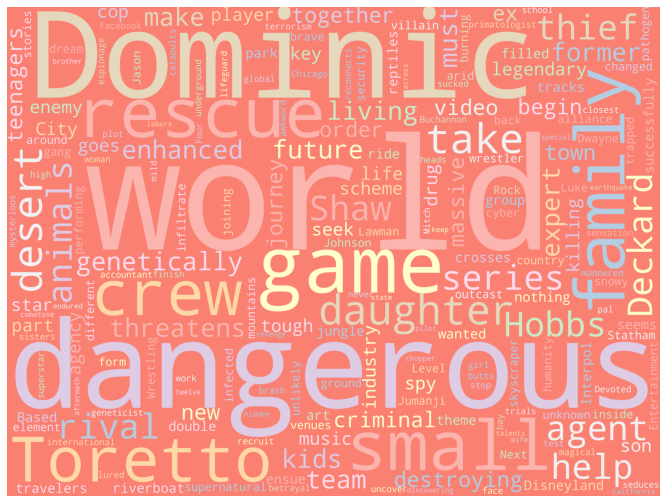

In [9]:
actor = ('Dwayne Johnson', 'https://www.imdb.com/name/nm0425005/')
actor_page_soup = get_some_page_soup(actor[1])
result = get_movie_descriptions_by_actor_soup(actor_page_soup)
text = ''.join(result)

stopwords = set(STOPWORDS)
stopwords.add("will")
stopwords.add("way")
stopwords.add("find")
stopwords.add("gets")
stopwords.add("return")
stopwords.add("three")
stopwords.add("one")
stopwords.add("two")
stopwords.add("plan")
stopwords.add("escape")
stopwords.add("become")

word_cloud = WordCloud(
        width=4000,
        height=3000,
        random_state=1,
        background_color="salmon",
        colormap="Pastel1",
        collocations=False,
        stopwords=stopwords,
        ).generate(text)

plt.figure(figsize=[15,9])
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

# Chris Hemsworth (Using txt file)

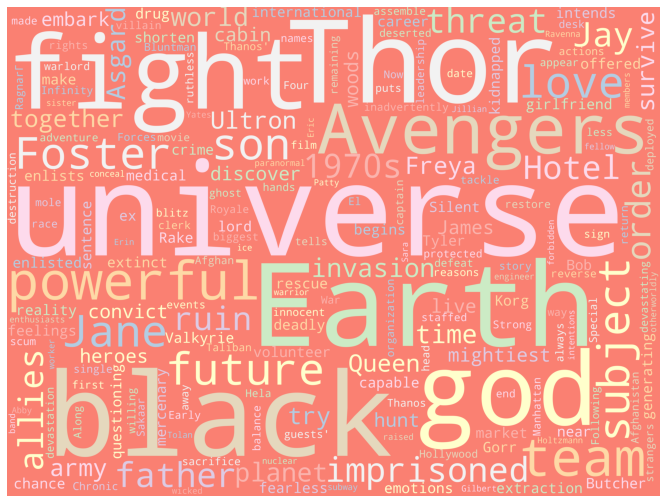

In [10]:
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
text = open(path.join(d, 'Chris Hemsworth.txt')).read()

stopwords = set(STOPWORDS)
stopwords.add("things")
stopwords.add("two")
stopwords.add("take")
stopwords.add("go")
stopwords.add("men")
stopwords.add("one")
stopwords.add("help")
stopwords.add("plan")
stopwords.add("attempt")
stopwords.add("new")
stopwords.add("stop")
stopwords.add("must")
stopwords.add("check")

word_cloud = WordCloud(
        width=4000,
        height=3000,
        random_state=1,
        background_color="salmon",
        colormap="Pastel1",
        collocations=False,
        stopwords=stopwords,
        ).generate(text)

plt.figure(figsize=[15,9])
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

# Chris Hemsworth (Using actor_page_soup)

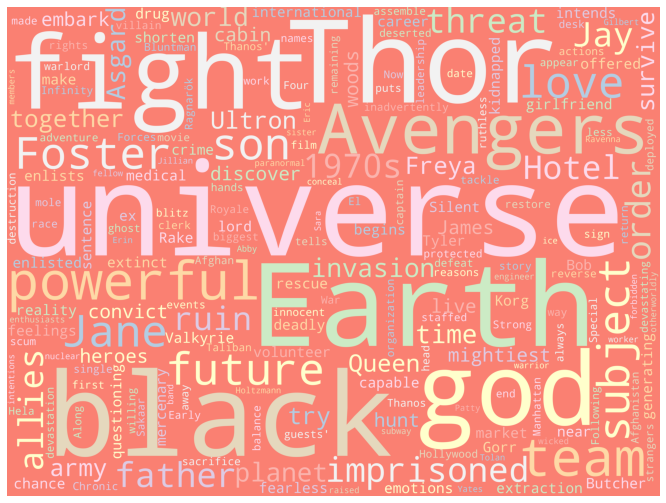

In [11]:
actor = ('Chris Hemsworth', 'https://www.imdb.com/name/nm1165110/')
actor_page_soup = get_some_page_soup(actor[1])
result = get_movie_descriptions_by_actor_soup(actor_page_soup)
text = ''.join(result)

stopwords = set(STOPWORDS)
stopwords.add("things")
stopwords.add("two")
stopwords.add("take")
stopwords.add("go")
stopwords.add("men")
stopwords.add("one")
stopwords.add("help")
stopwords.add("plan")
stopwords.add("attempt")
stopwords.add("new")
stopwords.add("stop")
stopwords.add("must")
stopwords.add("check")


word_cloud = WordCloud(
        width=4000,
        height=3000,
        random_state=1,
        background_color="salmon",
        colormap="Pastel1",
        collocations=False,
        stopwords=stopwords,
        ).generate(text)

plt.figure(figsize=[15,9])
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

# Robert Downey Jr. (Using txt file)

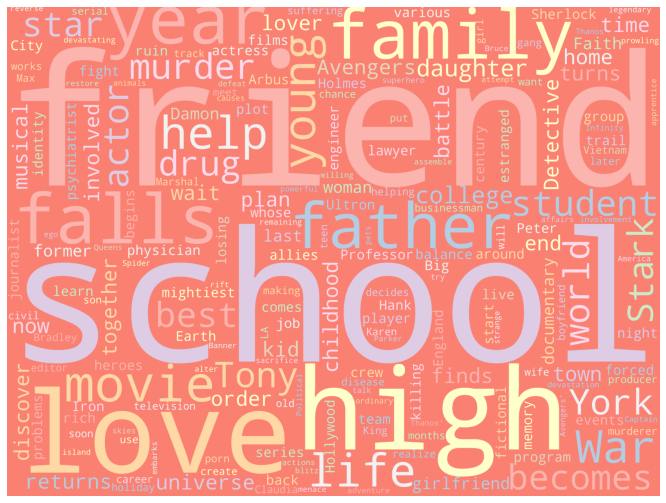

In [12]:
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
text = open(path.join(d, 'Robert Downey Jr..txt')).read()


stopwords = set(STOPWORDS)
stopwords.add("new")
stopwords.add("man")
stopwords.add("must")
stopwords.add("find")
stopwords.add("become")
stopwords.add("stop")
stopwords.add("make")
stopwords.add("tries")
stopwords.add("return")
stopwords.add("way")
stopwords.add("called")
stopwords.add("come")
stopwords.add("one")
stopwords.add("two")
stopwords.add("film")


word_cloud = WordCloud(
        width=4000,
        height=3000,
        random_state=1,
        background_color="salmon",
        colormap="Pastel1",
        collocations=False,
        stopwords=stopwords,
        ).generate(text)

plt.figure(figsize=[15,9])
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

# Robert Downey Jr. (Using actor_page_soup)

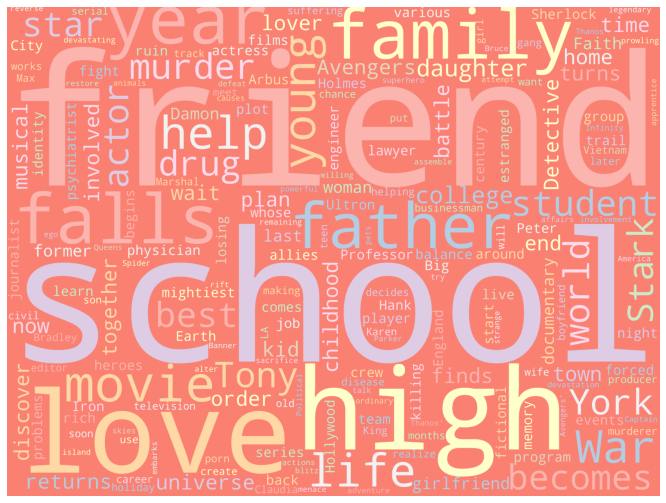

In [13]:
actor = ('Robert Downey Jr.', 'https://www.imdb.com/name/nm0000375/')
actor_page_soup = get_some_page_soup(actor[1])
result = get_movie_descriptions_by_actor_soup(actor_page_soup)
text = ''.join(result)

stopwords = set(STOPWORDS)
stopwords.add("new")
stopwords.add("man")
stopwords.add("must")
stopwords.add("find")
stopwords.add("become")
stopwords.add("stop")
stopwords.add("make")
stopwords.add("tries")
stopwords.add("return")
stopwords.add("way")
stopwords.add("called")
stopwords.add("come")
stopwords.add("one")
stopwords.add("two")
stopwords.add("film")

word_cloud = WordCloud(
        width=4000,
        height=3000,
        random_state=1,
        background_color="salmon",
        colormap="Pastel1",
        collocations=False,
        stopwords=stopwords,
        ).generate(text)

plt.figure(figsize=[15,9])
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

# Akshay Kumar (Using txt file)

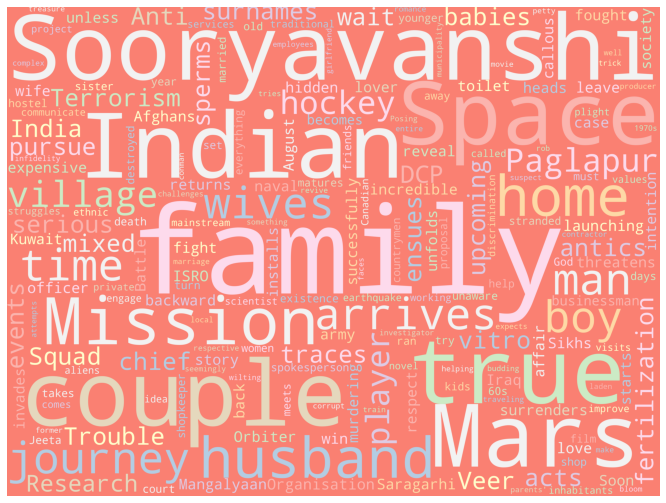

In [14]:
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
text = open(path.join(d, 'Akshay Kumar.txt')).read()

stopwords = set(STOPWORDS)
stopwords.add("based")
stopwords.add("three")
stopwords.add("woman")
stopwords.add("two")
stopwords.add("young")
stopwords.add("find")
stopwords.add("least")
stopwords.add("making")

word_cloud = WordCloud(
        width=4000,
        height=3000,
        random_state=1,
        background_color="salmon",
        colormap="Pastel1",
        collocations=False,
        stopwords=stopwords,
        ).generate(text)

plt.figure(figsize=[15,9])
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

# Akshay Kumar (Using actor_page_soup)

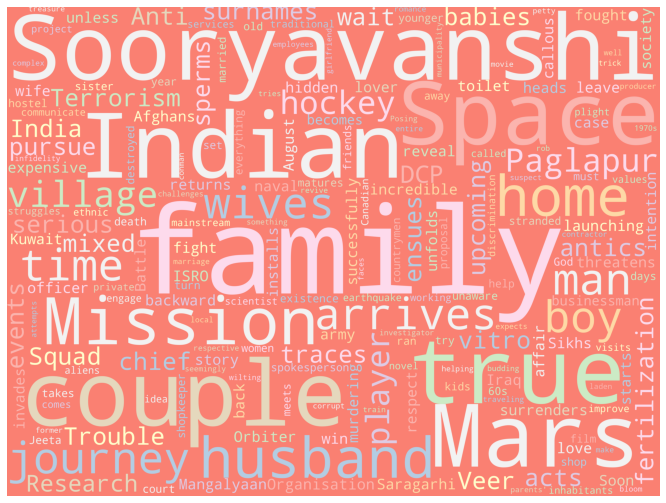

In [15]:
actor = ('Akshay Kumar', 'https://www.imdb.com/name/nm0474774/')
actor_page_soup = get_some_page_soup(actor[1])
result = get_movie_descriptions_by_actor_soup(actor_page_soup)
text = ''.join(result)

stopwords = set(STOPWORDS)
stopwords.add("based")
stopwords.add("three")
stopwords.add("woman")
stopwords.add("two")
stopwords.add("young")
stopwords.add("find")
stopwords.add("least")
stopwords.add("making")

word_cloud = WordCloud(
        width=4000,
        height=3000,
        random_state=1,
        background_color="salmon",
        colormap="Pastel1",
        collocations=False,
        stopwords=stopwords,
        ).generate(text)

plt.figure(figsize=[15,9])
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

# Jackie Chan (Using txt file)

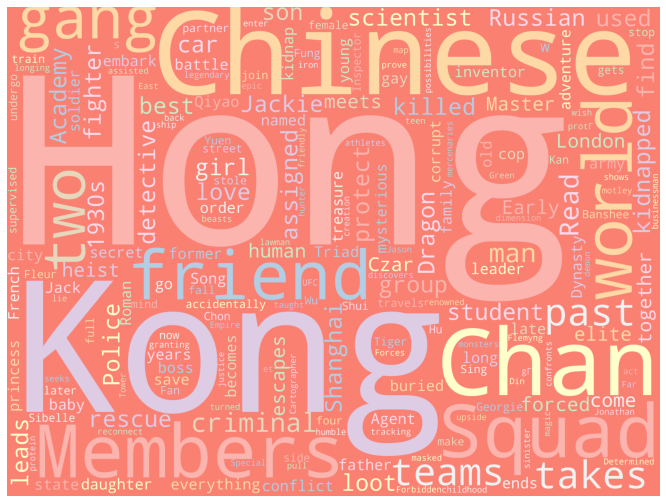

In [16]:
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
text = open(path.join(d, 'Jackie Chan.txt')).read()

stopwords = set(STOPWORDS)
stopwords.add("take")
stopwords.add("team")
stopwords.add("china")
stopwords.add("general")
stopwords.add("three")
stopwords.add("new")
stopwords.add("lead")
stopwords.add("take")
stopwords.add("one")
stopwords.add("new")
stopwords.add("instead")
stopwords.add("al")
stopwords.add("life")

word_cloud = WordCloud(
        width=4000,
        height=3000,
        random_state=1,
        background_color="salmon",
        colormap="Pastel1",
        collocations=False,
        stopwords=stopwords,
        ).generate(text)

plt.figure(figsize=[15,9])
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

# Jackie Chan (Using actor_page_soup)


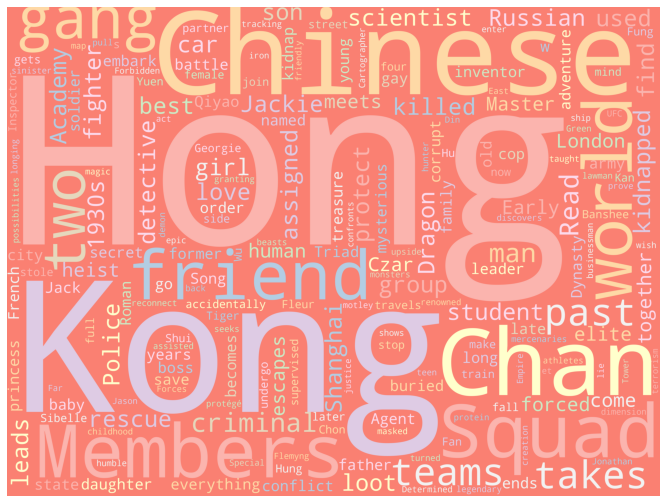

In [17]:
actor = ('Jackie Chan', 'https://www.imdb.com/name/nm0000329/')
actor_page_soup = get_some_page_soup(actor[1])
result = get_movie_descriptions_by_actor_soup(actor_page_soup)
text = ''.join(result)

stopwords = set(STOPWORDS)
stopwords.add("take")
stopwords.add("team")
stopwords.add("china")
stopwords.add("general")
stopwords.add("three")
stopwords.add("new")
stopwords.add("lead")
stopwords.add("take")
stopwords.add("one")
stopwords.add("new")
stopwords.add("instead")
stopwords.add("al")
stopwords.add("life")

word_cloud = WordCloud(
        width=4000,
        height=3000,
        random_state=1,
        background_color="salmon",
        colormap="Pastel1",
        collocations=False,
        stopwords=stopwords,
        ).generate(text)

plt.figure(figsize=[15,9])
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

# Bradley Cooper (Using txt file)

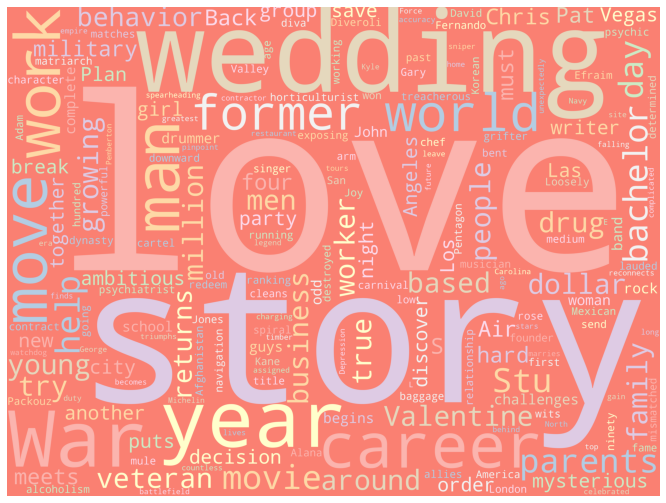

In [18]:
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
text = open(path.join(d, 'Bradley Cooper.txt')).read()

stopwords = set(STOPWORDS)
stopwords.add("way")
stopwords.add("find")
stopwords.add("two")
stopwords.add("one")
stopwords.add("make")
stopwords.add("become")
stopwords.add("turns")
stopwords.add("find")
stopwords.add("set")
stopwords.add("three")
stopwords.add("instead")


word_cloud = WordCloud(
        width=4000,
        height=3000,
        random_state=1,
        background_color="salmon",
        colormap="Pastel1",
        collocations=False,
        stopwords=stopwords,
        ).generate(text)

plt.figure(figsize=[15,9])
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

# Bradley Cooper (Using actor_page_soup)

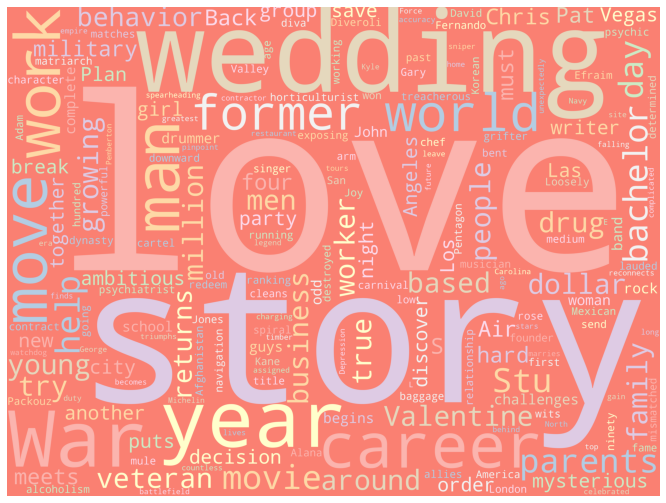

In [19]:
actor = ('Bradley Cooper', 'https://www.imdb.com/name/nm0177896/')
actor_page_soup = get_some_page_soup(actor[1])
result = get_movie_descriptions_by_actor_soup(actor_page_soup)
text = ''.join(result)

stopwords = set(STOPWORDS)
stopwords.add("way")
stopwords.add("find")
stopwords.add("two")
stopwords.add("one")
stopwords.add("make")
stopwords.add("become")
stopwords.add("turns")
stopwords.add("find")
stopwords.add("set")
stopwords.add("three")
stopwords.add("instead")

word_cloud = WordCloud(
        width=4000,
        height=3000,
        random_state=1,
        background_color="salmon",
        colormap="Pastel1",
        collocations=False,
        stopwords=stopwords,
        ).generate(text)

plt.figure(figsize=[15,9])
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

# Adam Sandler (Using txt file)

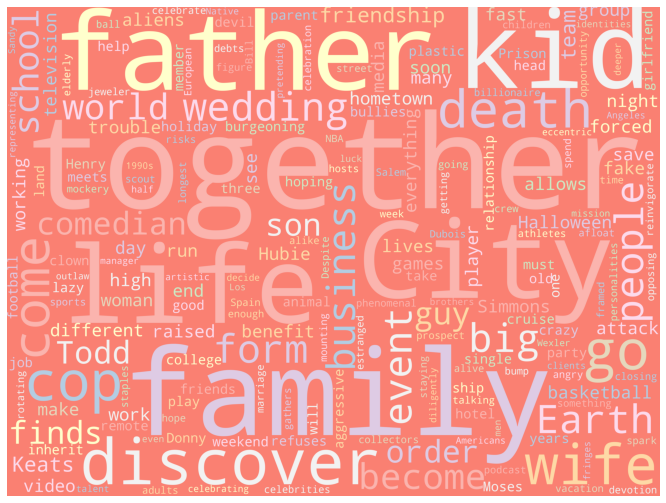

In [20]:
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
text = open(path.join(d, 'Adam Sandler.txt')).read()

stopwords = set(STOPWORDS)
stopwords.add("two")
stopwords.add("new")
stopwords.add("find")
stopwords.add("man")
stopwords.add("start")
stopwords.add("back")
stopwords.add("year")
stopwords.add("York")
stopwords.add("five")
stopwords.add("show")
stopwords.add("way")
stopwords.add("start")

word_cloud = WordCloud(
        width=4000,
        height=3000,
        random_state=1,
        background_color="salmon",
        colormap="Pastel1",
        collocations=False,
        stopwords=stopwords,
        ).generate(text)

plt.figure(figsize=[15,9])
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

# Adam Sandler (Using actor_page_soup)

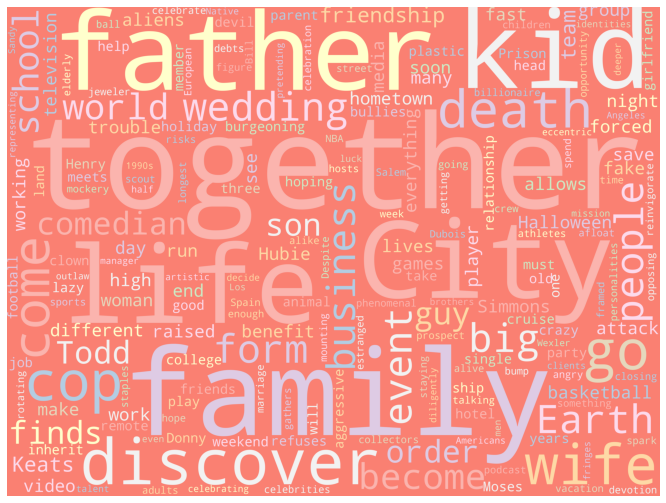

In [21]:
actor = ('Adam Sandler', 'https://www.imdb.com/name/nm0001191/')
actor_page_soup = get_some_page_soup(actor[1])
result = get_movie_descriptions_by_actor_soup(actor_page_soup)
text = ''.join(result)

stopwords = set(STOPWORDS)
stopwords.add("two")
stopwords.add("new")
stopwords.add("find")
stopwords.add("man")
stopwords.add("start")
stopwords.add("back")
stopwords.add("year")
stopwords.add("York")
stopwords.add("five")
stopwords.add("show")
stopwords.add("way")
stopwords.add("start")

word_cloud = WordCloud(
        width=4000,
        height=3000,
        random_state=1,
        background_color="salmon",
        colormap="Pastel1",
        collocations=False,
        stopwords=stopwords,
        ).generate(text)

plt.figure(figsize=[15,9])
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

# Scarlett Johansson (Using txt file)

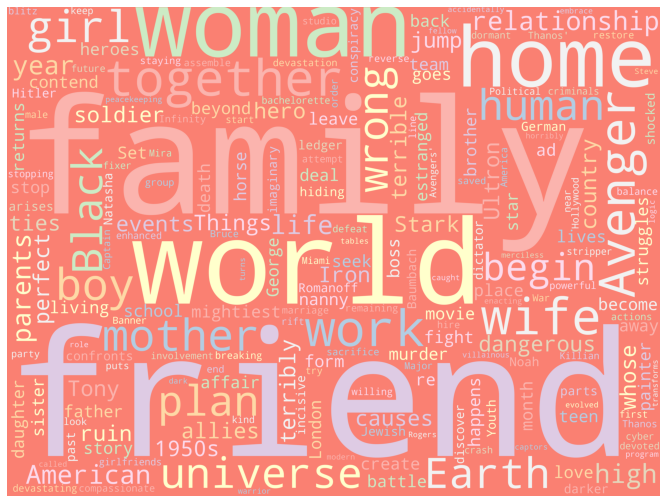

In [22]:
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
text = open(path.join(d, 'Scarlett Johansson.txt')).read()

stopwords = set(STOPWORDS)
stopwords.add("two")
stopwords.add("new")
stopwords.add("must")
stopwords.add("young")
stopwords.add("man")
stopwords.add("go")
stopwords.add("fall")
stopwords.add("help")
stopwords.add("find")


word_cloud = WordCloud(
        width=4000,
        height=3000,
        random_state=1,
        background_color="salmon",
        colormap="Pastel1",
        collocations=False,
        stopwords=stopwords,
        ).generate(text)

plt.figure(figsize=[15,9])
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

# Scarlett Johansson (Using actor_page_soup)

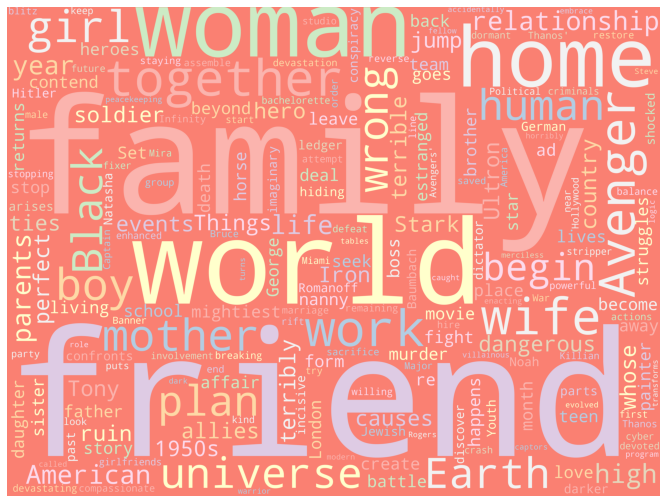

In [23]:
actor = ('Scarlett Johansson', 'https://www.imdb.com/name/nm0424060/')
actor_page_soup = get_some_page_soup(actor[1])
result = get_movie_descriptions_by_actor_soup(actor_page_soup)
text = ''.join(result)

stopwords = set(STOPWORDS)
stopwords.add("two")
stopwords.add("new")
stopwords.add("must")
stopwords.add("young")
stopwords.add("man")
stopwords.add("go")
stopwords.add("fall")
stopwords.add("help")
stopwords.add("find")


word_cloud = WordCloud(
        width=4000,
        height=3000,
        random_state=1,
        background_color="salmon",
        colormap="Pastel1",
        collocations=False,
        stopwords=stopwords,
        ).generate(text)

plt.figure(figsize=[15,9])
plt.imshow(word_cloud)
plt.axis("off")
plt.show()


# Sofia Vergara (Using txt file)

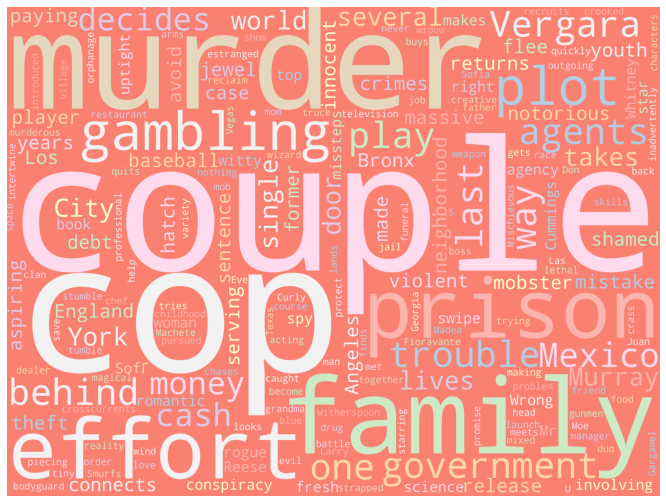

In [24]:
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
text = open(path.join(d, 'Sofia Vergara.txt')).read()

stopwords = set(STOPWORDS)
stopwords.add("decide")
stopwords.add("take")
stopwords.add("new")
stopwords.add("find")
stopwords.add("three")
stopwords.add("year")
stopwords.add("look")



word_cloud = WordCloud(
        width=4000,
        height=3000,
        random_state=1,
        background_color="salmon",
        colormap="Pastel1",
        collocations=False,
        stopwords=stopwords,
        ).generate(text)

plt.figure(figsize=[15,9])
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

# Sofia Vergara (Using actor_page_soup)

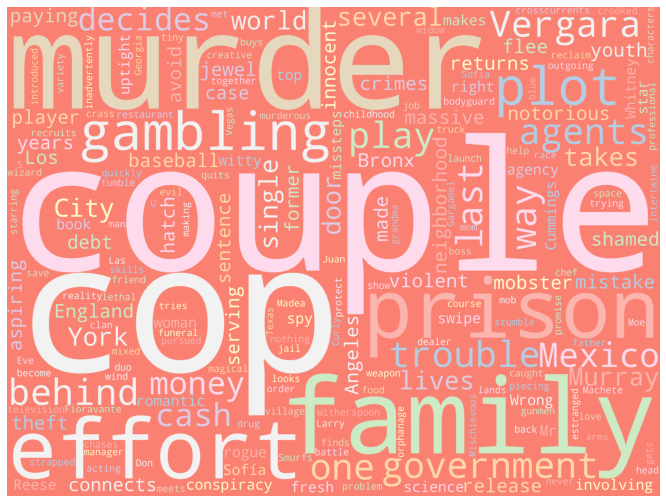

In [25]:
actor = ('Sofia Vergara', 'https://www.imdb.com/name/nm0005527/')
actor_page_soup = get_some_page_soup(actor[1])
result = get_movie_descriptions_by_actor_soup(actor_page_soup)
text = ''.join(result)

stopwords = set(STOPWORDS)
stopwords.add("decide")
stopwords.add("take")
stopwords.add("new")
stopwords.add("find")
stopwords.add("three")
stopwords.add("year")
stopwords.add("look")


word_cloud = WordCloud(
        width=4000,
        height=3000,
        random_state=1,
        background_color="salmon",
        colormap="Pastel1",
        collocations=False,
        stopwords=stopwords,
        ).generate(text)

plt.figure(figsize=[15,9])
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

# Chris Evans (Using txt file)

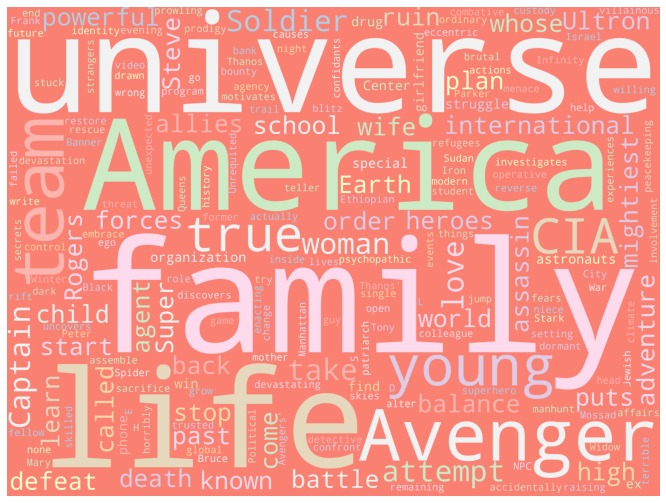

In [26]:
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
text = open(path.join(d, 'Chris Evans.txt')).read()

stopwords = set(STOPWORDS)
stopwords.add("new")
stopwords.add("man")
stopwords.add("must")
stopwords.add("york")
stopwords.add("three")
stopwords.add("one")
stopwords.add("two")


word_cloud = WordCloud(
        width=4000,
        height=3000,
        random_state=1,
        background_color="salmon",
        colormap="Pastel1",
        collocations=False,
        stopwords=stopwords,
        ).generate(text)

plt.figure(figsize=[15,9])
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

# Chris Evans (Using actor_page_soup)

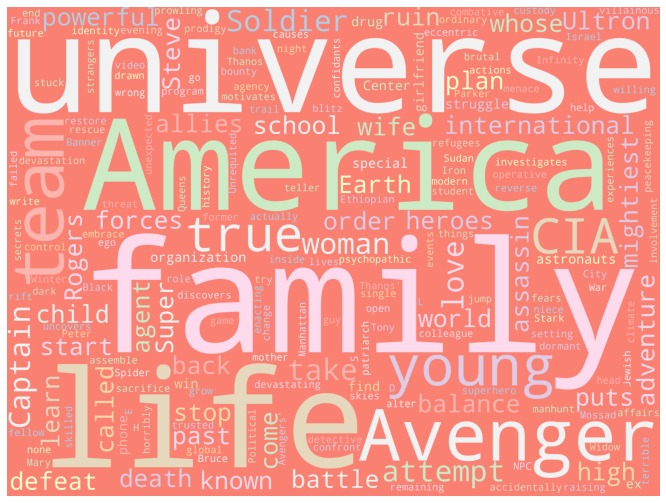

In [27]:
actor = ('Chris Evans', 'https://www.imdb.com/name/nm0262635/') 
actor_page_soup = get_some_page_soup(actor[1])
result = get_movie_descriptions_by_actor_soup(actor_page_soup)
text = ''.join(result)

stopwords = set(STOPWORDS)
stopwords.add("new")
stopwords.add("man")
stopwords.add("must")
stopwords.add("york")
stopwords.add("three")
stopwords.add("one")
stopwords.add("two")

word_cloud = WordCloud(
        width=4000,
        height=3000,
        random_state=1,
        background_color="salmon",
        colormap="Pastel1",
        collocations=False,
        stopwords=stopwords,
        ).generate(text)

plt.figure(figsize=[15,9])
plt.imshow(word_cloud)
plt.axis("off")
plt.show()